In [1]:
import torch
import tqdm
import sys
sys.path.append("/home/zoker/quict")

from QuICT.algorithm.quantum_machine_learning.utils import Hamiltonian
from QuICT.algorithm.quantum_machine_learning.utils.ml_utils import *
from QuICT.algorithm.quantum_machine_learning.model.VQA import QAOANet
from QuICT.algorithm.tools.drawer.graph_drawer import *
from QuICT.simulation.state_vector import ConstantStateVectorSimulator

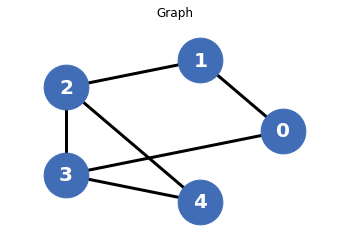

In [3]:
n = 5
nodes = list(range(n))
edges = [[0, 1], [1, 2], [2, 3], [3, 4], [0, 3], [2, 4]]
# 内置的画图函数可以打印生成的图G
draw_graph(nodes, edges)

In [4]:
def maxcut_hamiltonian(edges):
    pauli_list = []
    for edge in edges:
        pauli_list.append([-1.0, "Z" + str(edge[0]), "Z" + str(edge[1])])
    hamiltonian = Hamiltonian(pauli_list)

    return hamiltonian

H = maxcut_hamiltonian(edges)

H.pauli_str

[[-1.0, 'Z0', 'Z1'],
 [-1.0, 'Z1', 'Z2'],
 [-1.0, 'Z2', 'Z3'],
 [-1.0, 'Z3', 'Z4'],
 [-1.0, 'Z0', 'Z3'],
 [-1.0, 'Z2', 'Z4']]

In [5]:
qaoa_net_sample = QAOANet(n_qubits=n, p=1, hamiltonian=H)

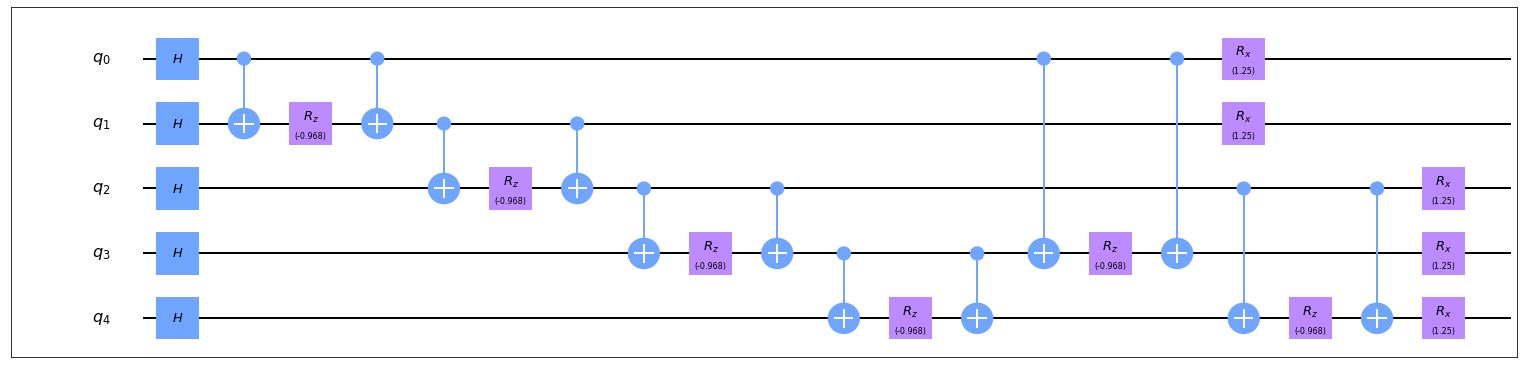

In [6]:
qaoa_cir_sample = qaoa_net_sample.construct_circuit()
qaoa_cir_sample.draw()

In [7]:
p = 4           # 量子电路层数
MAX_ITERS = 150 # 最大迭代次数
LR = 0.1        # 梯度下降的学习率
SEED = 17       # 随机数种子

set_seed(SEED)  # 设置全局随机种子

In [8]:
qaoa_net = QAOANet(n_qubits=n, p=p, hamiltonian=H)
optim = torch.optim.Adam([dict(params=qaoa_net.parameters(), lr=LR)])

# 开始训练
qaoa_net.train()
loader = tqdm.trange(MAX_ITERS, desc="Training", leave=True)
for it in loader:
    optim.zero_grad()
    state = qaoa_net()
    loss = qaoa_net.loss_func(state)
    loss.backward()
    optim.step()
    loader.set_postfix(loss=loss.item())

Training: 100%|██████████| 150/150 [00:52<00:00,  2.86it/s, loss=-3.74]


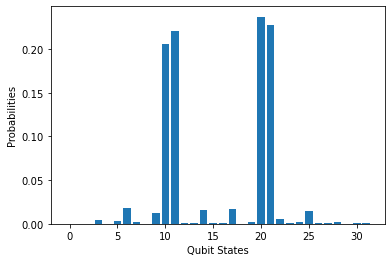

In [9]:
shots = 1000
qaoa_ansatz = qaoa_net.construct_ansatz()
prob = qaoa_ansatz.sample(shots)

plt.figure()
plt.xlabel("Qubit States")
plt.ylabel("Probabilities")
plt.bar(range(len(prob)), np.array(prob) / shots)
plt.savefig("/home/zoker/quict/maxcut_prob.png", transparent=True)
plt.show()

In [10]:
solution = prob.index(max(prob))
solution_bit = ("{:0" + str(n) + "b}").format(solution)
solution_bit

'10100'

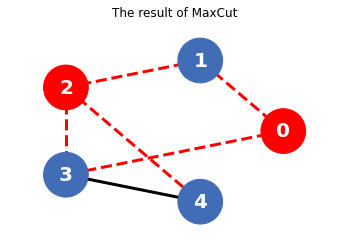

In [11]:
draw_maxcut_result(nodes, edges, solution_bit)